# Prepare run

## Import libraries and functions

In [ ]:
import os
import crested
import anndata
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from crested.tl.zoo import deeptopic_cnn
from crested.tl.data import AnnDataModule
from crested.tl import default_configs, TaskConfig

import matplotlib
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [2]:
from sklearn.utils import shuffle
from sklearn.metrics import average_precision_score, roc_auc_score

def shuffle_label(label):
    for i in range(len(label.T)):
        label.T[i] = shuffle(label.T[i])
    return label

def calculate_roc_pr(score, label):
    output = np.zeros((len(label.T), 2))
    for i in range(len(label.T)):
        roc_ = roc_auc_score(label.T[i], score.T[i])
        pr_ = average_precision_score(label.T[i], score.T[i])
        output[i] = [roc_, pr_]
    return output

## Setup directories

Download the data for the notebooks from the dedicated Zenodo link of the CREsted paper. Then use it below.

In [ ]:
data_dir = Path("../../../crested_data/Figure_4/deepglioma")

Output directory, to save the results from the analysis

In [ ]:
output_dir = Path(f'results')
output_path = data_dir.joinpath(output_dir)
Path(output_path).mkdir(parents=True, exist_ok=True)
Path(output_path.joinpath(Path("data"))).mkdir(parents=True, exist_ok=True)
Path(output_path.joinpath(Path("models"))).mkdir(parents=True, exist_ok=True)

Load hg38 genome

This notebook requires an hg38 fasta file and an hg38 chromosome sizes file. You can download that here for example: https://hgdownload.soe.ucsc.edu/downloads.html Once downloaded, we load them to the notebook.

In [ ]:
genome_dir = "../../../human/genome/"
genome_fasta = f"{genome_dir}hg38.fa"
genome_chrom_sizes  = f"{genome_dir}hg38.chrom.sizes"

genome = crested.Genome(genome_fasta, genome_chrom_sizes)
crested.register_genome(genome)

# Train DeepGlioma

## Load and process data

### Import topics

In [6]:
adata = crested.import_beds(
    beds_folder=data_dir.joinpath(Path("topic_binarization/bed_otsu")),
    chromsizes_file=genome_chrom_sizes,
    classes_subset=[f'Topic{x}' for x in range(1, 26) if x != 3],
)

adata

2025-03-30T05:48:56.582806+0200 INFO Reading bed files from /staging/leuven/stg_00002/lcb/vkonst/Projects/CREsted/data/deepglioma/topic_binarization/bed_otsu without consensus regions...


AnnData object with n_obs × n_vars = 24 × 250374
    obs: 'file_path', 'n_open_regions'
    var: 'n_classes', 'chr', 'start', 'end'

### Train/Val/Test split

In [7]:
crested.pp.train_val_test_split(
    adata,
    strategy="chr",
    val_chroms=["chr8", "chr9", "chr10"],
    test_chroms=["chr5", "chr6"]
)

print(adata.var["split"].value_counts())
adata.var.head()

split
train    192256
val       33229
test      24889
Name: count, dtype: int64


,n_classes,chr,start,end,split
chr1:827282-827782,4,chr1,827282,827782,train
chr1:869748-870248,1,chr1,869748,870248,train
chr1:902071-902571,2,chr1,902071,902571,train
chr1:903879-904379,2,chr1,903879,904379,train
chr1:905032-905532,2,chr1,905032,905532,train


#### Save data

In [8]:
adata.write_h5ad(output_path.joinpath(Path("data/otsu_data.h5ad")))

## Train model

In [9]:
# load your processed data
adata = anndata.read_h5ad(output_path.joinpath(Path("data/otsu_data.h5ad")))

### EDA

In [10]:
for i in range(0, 24):
    print(adata.obs_names[i])
    unique, counts = np.unique(adata.X[i, :], return_counts=True)
    unique = unique.tolist()
    counts = ((counts * 100)/len(adata.X[i, :])).tolist()
    percs = dict(zip(unique, counts))
    print(percs)

Topic1
{0: 96.1186065645794, 1: 3.8813934354206108}
Topic10
{0: 94.31091087732752, 1: 5.689089122672482}
Topic11
{0: 87.21712318371716, 1: 12.78287681628284}
Topic12
{0: 84.72085759703484, 1: 15.279142402965164}
Topic13
{0: 83.43957439670254, 1: 16.560425603297467}
Topic14
{0: 95.68166023628652, 1: 4.318339763713484}
Topic15
{0: 81.95938875442339, 1: 18.040611245576617}
Topic16
{0: 92.7460519063481, 1: 7.253948093651897}
Topic17
{0: 99.52031760486312, 1: 0.4796823951368752}
Topic18
{0: 94.73907035075527, 1: 5.26092964924473}
Topic19
{0: 94.0145542268766, 1: 5.985445773123407}
Topic2
{0: 94.27855927532411, 1: 5.721440724675885}
Topic20
{0: 93.34675325712733, 1: 6.653246742872662}
Topic21
{0: 92.67176304248844, 1: 7.328236957511563}
Topic22
{0: 94.83292993681452, 1: 5.1670700631854745}
Topic23
{0: 91.56741514694018, 1: 8.432584853059822}
Topic24
{0: 93.39148633644068, 1: 6.608513663559315}
Topic25
{0: 89.99936095600981, 1: 10.00063904399019}
Topic4
{0: 88.69651002100858, 1: 11.3034899789

### Initialize data module

In [11]:
datamodule = AnnDataModule(
    adata,
    chromsizes_file=genome_chrom_sizes,
    batch_size=128,
    max_stochastic_shift=50,
    always_reverse_complement=True,
)

### Define model and task

In [12]:
model = deeptopic_cnn(seq_len=500, num_classes=24)
config = default_configs("topic_classification")
print(config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x146c79c78790>, loss=<LossFunctionWrapper(<function binary_crossentropy at 0x146c79e24ea0>, kwargs={'from_logits': False, 'label_smoothing': 0.0, 'axis': -1})>, metrics=[<AUC name=auROC>, <AUC name=auPR>, <CategoricalAccuracy name=categorical_accuracy>])


### Training

In [13]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model,
    config=config,
    project_name="deepglioma_training",
    run_name="deepglioma",
    logger="wandb",
    seed=42,
)

In [ ]:
# train the model
trainer.fit(
    epochs=100,
    save_dir=str(output_path.joinpath(Path("deepglioma_training")))
)

# Evaluate DeepGlioma (Figure S11b)

In [14]:
adata = anndata.read_h5ad(output_path.joinpath(Path("data/otsu_data.h5ad")))
datamodule = AnnDataModule(
    adata,
    chromsizes_file=genome_chrom_sizes,
    batch_size=512,
    max_stochastic_shift=0,
    always_reverse_complement=False,
)

DeepGlioma

In [15]:
evaluator = crested.tl.Crested(data=datamodule)
evaluator.load_model(
    output_path.joinpath(Path("models/DeepGlioma.keras")),
    compile=True,
)
evaluator.predict(
    adata,
    model_name="DeepGlioma"
)

2025-03-30T05:51:31.778285+0200 INFO Adding predictions to anndata.layers[DeepGlioma].


## Figure S11b

Calculate ROC and PR...


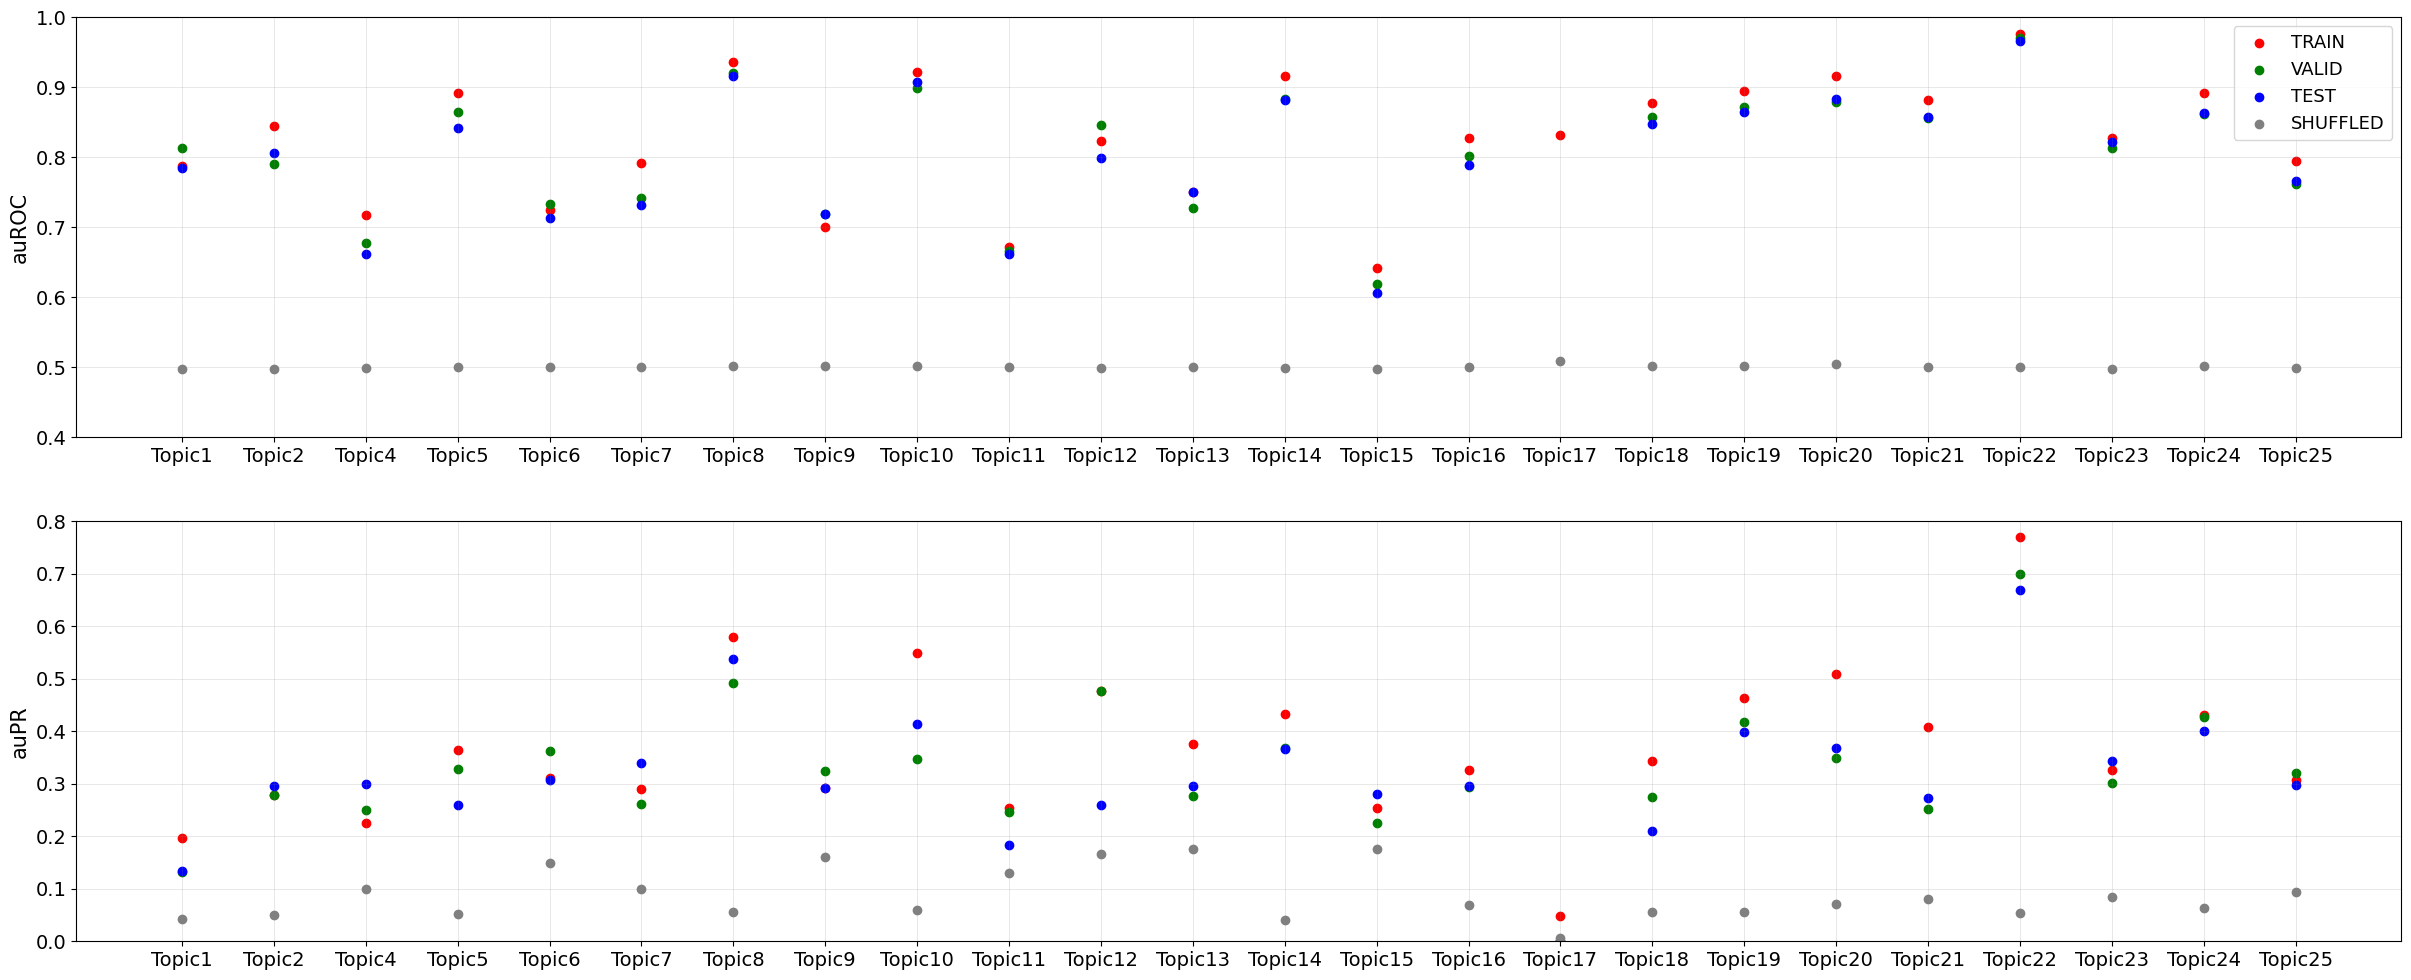

Mean Train ROC and PR = [0.82664563 0.36723081]
Mean Valid ROC and PR = [0.78937208 0.32088641]
Mean Test ROC and PR = [0.77876905 0.31314951]
Mean Shuffle ROC and PR = [0.50059242 0.08703453]


In [16]:
model_name = 'DeepGlioma'
sorted_topics = sorted(adata.obs_names, key=lambda x: int(x[5:]))
adata_sorted = adata[sorted_topics, :].copy()
selected_classes = np.array(list(range(adata_sorted.X.shape[0])))

print('Calculate ROC and PR...')
roc_pr_dict = {"train": {}, "val": {}, "test": {}, "shuffle": {}}

for sets in ["train", "val", "test", "shuffle"]:
    if sets == "shuffle":
        roc_pr_dict["shuffle"]["prediction"] = np.array(roc_pr_dict["train"]["prediction"], copy=True)
        roc_pr_dict["shuffle"]["label"] = shuffle_label(np.array(roc_pr_dict["train"]["label"], copy=True))
    else:
        roc_pr_dict[sets]["prediction"] = adata_sorted.layers[model_name][:, adata_sorted.var['split'] == sets].T
        roc_pr_dict[sets]["label"] = adata_sorted.X[:, adata_sorted.var['split'] == sets].T

for sets in ["train", "val", "test", "shuffle"]:
    roc_pr_dict[sets]["roc_pr"] = calculate_roc_pr(roc_pr_dict[sets]["prediction"], roc_pr_dict[sets]["label"])

fig = plt.figure(figsize=(30, 12))

ax = fig.add_subplot(2, 1, 1)
ax.set_ylabel('auROC', fontsize=15)
ax.scatter(selected_classes, roc_pr_dict["train"]["roc_pr"].T[0], color='red', label='TRAIN')
ax.scatter(selected_classes, roc_pr_dict["val"]["roc_pr"].T[0], color='green', label='VALID')
ax.scatter(selected_classes, roc_pr_dict["test"]["roc_pr"].T[0], color='blue', label='TEST')
ax.scatter(selected_classes, roc_pr_dict["shuffle"]["roc_pr"].T[0], color='gray', label='SHUFFLED')
ax.set_ylim([0.4, 1])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.25)
_ = plt.xticks(range(len(selected_classes)), sorted_topics)
ax.legend(fontsize=13, bbox_to_anchor=(1, 1))

ax = fig.add_subplot(2, 1, 2)
ax.set_ylabel('auPR', fontsize=15)
ax.scatter(selected_classes, roc_pr_dict["train"]["roc_pr"].T[1], color='red', label='TRAIN')
ax.scatter(selected_classes, roc_pr_dict["val"]["roc_pr"].T[1], color='green', label='VALID')
ax.scatter(selected_classes, roc_pr_dict["test"]["roc_pr"].T[1], color='blue', label='TEST')
ax.scatter(selected_classes, roc_pr_dict["shuffle"]["roc_pr"].T[1], color='gray', label='SHUFFLED')
ax.set_ylim([0, 0.8])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.25)
_ = plt.xticks(range(len(selected_classes)), sorted_topics)
plt.show()

print(f"Mean Train ROC and PR = {roc_pr_dict['train']['roc_pr'].mean(axis=0)}")
print(f"Mean Valid ROC and PR = {roc_pr_dict['val']['roc_pr'].mean(axis=0)}")
print(f"Mean Test ROC and PR = {roc_pr_dict['test']['roc_pr'].mean(axis=0)}")
print(f"Mean Shuffle ROC and PR = {roc_pr_dict['shuffle']['roc_pr'].mean(axis=0)}")

Save anndata with predictions

In [17]:
adata.write_h5ad(output_path.joinpath(Path("data/otsu_data_pred.h5ad")))

# Interpret DeepGlioma predictions (Part of Figure 4d)

In [18]:
adata = anndata.read_h5ad(output_path.joinpath(Path("data/otsu_data_pred.h5ad")))
datamodule = AnnDataModule(
    adata,
    chromsizes_file=genome_chrom_sizes,
    batch_size=512,
    max_stochastic_shift=0,
    always_reverse_complement=False,
)

evaluator = crested.tl.Crested(data=datamodule)
evaluator.load_model(
    output_path.joinpath(Path("models/DeepGlioma.keras")),
    compile=True,
)

### AXL

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted topic: Topic8


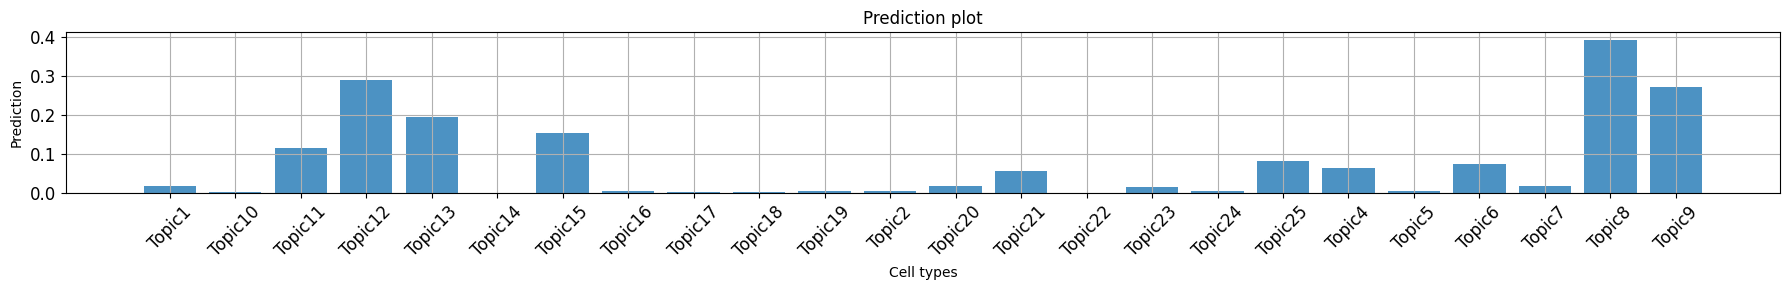

In [19]:
# AXL chr19:41223464-41223964
regions_of_interest = [
    "chr19:41223464-41223964"
]

prediction = evaluator.predict_regions(regions_of_interest)
print(f'Predicted topic: {adata.obs_names[prediction.argmax()]}')
crested.pl.bar.prediction(prediction, classes=adata.obs_names, x_label_rotation=45)

#### Topic 8/19

In [20]:
scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_regions(
    region_idx=regions_of_interest,
    class_names=['Topic8', 'Topic19'],
    method='expected_integrated_grad',
)

Region: 100%|██████████| 1/1 [00:22<00:00, 22.71s/it]


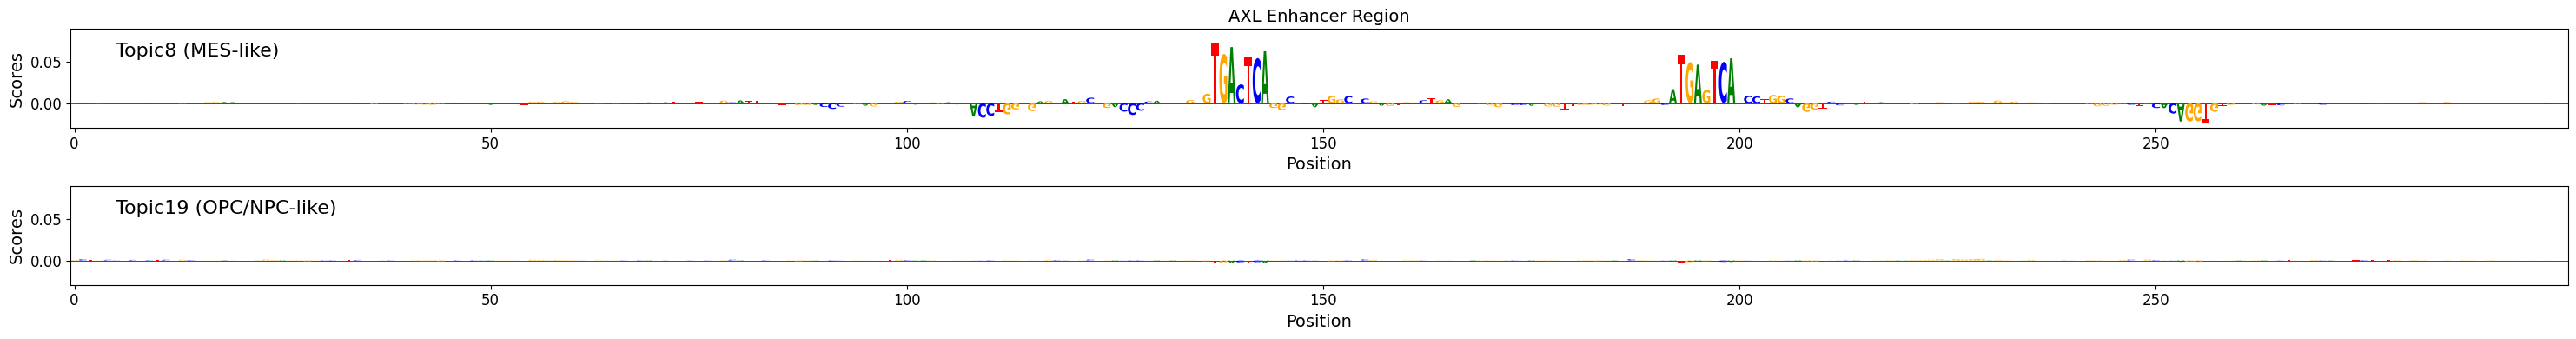

In [21]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=["AXL Enhancer Region"],
    class_labels=['Topic8 (MES-like)', 'Topic19 (OPC/NPC-like)'],
    zoom_n_bases=300,
)